In [1]:
# Modules

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import csv
#from implementations_ben import *


# Files 
x_train_csv = "dataset/x_train.csv"
y_train_csv = "dataset/y_train.csv"



# Own functions
#from real_implementations import *

In [2]:


def k_fold_cross_validation(X, y, max_iters, gammas, K, seed,reg_norm=''):
    """
    Runs k-fold cross-validation for a given dataset, a list of learning rates, and other configurable parameters.

    max_iters : int
        Maximum number of iterations for optimization.

    gammas : array-like
        A list of learning rates (gammas) to evaluate.

    K : int
        The number of folds for cross-validation.

    seed : int
        Random seed to ensure reproducibility of the k-fold splits.
    
    reg_norm: norm: 'l2' for ridge (L2 norm) or 'l1' for lasso (L1 norm) regularization; by default none
    """
    
    # Initial weights (small random values)
    initial_w = np.random.rand(X.shape[1]) * 0.01
    # Split data into k folds
    k_indices = build_k_indices(y, K, seed)
    
    # Define lists to store the loss of training data and test data
    loss_tr_list = []
    loss_te_list = []
    
    # For each gamma, perform cross-validation
    for gamma in gammas:
        loss_tr = 0
        loss_te = 0
        for k in tqdm(range(K)):
            losses_tr, losses_te, w = cross_validation(y, X, k_indices, k, initial_w, max_iters, gamma, reg_norm)
            
            if k == 0:
                plot_loss_iter(losses_train=losses_tr, losses_test=losses_te, max_iters=max_iters, gamma=gamma)
            
            # Accumulate the last loss of the training and test sets
            loss_tr += losses_tr[max_iters - 1]
            loss_te += losses_te[max_iters - 1]
        
        # Average over all k folds
        loss_tr_list.append(loss_tr / K)
        loss_te_list.append(loss_te / K)
        
        print(f'Learning rate = {gamma}; Average train loss = {loss_tr / K}; Average test loss: {loss_te / K}')
    
    # Create a dictionary that pairs gamma with the corresponding test loss (MSE)
    gamma_mse_dict = {gammas[i]: loss_te_list[i] for i in range(len(gammas))}
    
    # Sort the dictionary by test loss (MSE)
    sorted_gamma_mse = dict(sorted(gamma_mse_dict.items(), key=lambda item: item[1]))
    
    # Retrieve the best gamma (learning rate) with the lowest MSE
    best_gamma, best_mse = list(sorted_gamma_mse.items())[0]
    
    print(f'Best learning rate: {best_gamma} with test MSE: {best_mse}')
    
    return best_gamma, best_mse, sorted_gamma_mse

def train_test_split(X,y, training_split):
    '''
      Splits the dataset into training and test sets based on a training split ratio.
    '''
    N = np.shape(y)[0] # number of samples
    random_index = np.random.permutation(N)
    # Proportion trainig: 0.9; test: 0.1´
    N_train = int(training_split * N)
    training_index = random_index[:N_train]
    test_index = random_index[N_train:]
    x_tr = X[training_index]
    x_te = X[test_index]
    y_tr = y[training_index]
    y_te = y[test_index]
    
    return x_tr, y_tr, x_te, y_te

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold
        # For each row one fold, where elements are elements per fold (indicated by indices)

    >>> build_k_indices(np.array([1., 2., 3., 4.]), 2, 1)
    array([[3, 2],
           [0, 1]])
    """
    num_row = y.shape[0]  # number of samples
    interval = int(num_row / k_fold)  # number of samples per row
    np.random.seed(seed)
    indices = np.random.permutation(
        num_row
    )  # create array with N elements from 0...N, shuffled

    # Group indices into arrays: do it K times ( so K folds)
    # take indices[0:i]; where i num of samples per fold; iteratively
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


def cross_validation(y, x, k_indices, k, initial_w, max_iters, gamma, reg_norm):
    """return the loss for a fold (only for one FOLD) corresponding to k_indices

    Args:
        y:          shape=(N,)
        x:          shape=(N,)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        initial_w:  initial weights
    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)

    >>> cross_validation(np.array([1.,2.,3.,4.]), np.array([6.,7.,8.,9.]), np.array([[3,2], [0,1]]), 1, 2, 3)
    (0.019866645527597114, 0.33555914361295175)
    """

    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train
    # Once have k folds, separate k -1 into train and leave one for test
    # Ex: choose k for test and remaining for training

    idx_te = k_indices[k]
    idx_tr = k_indices[
        np.arange(len(k_indices)) != k
    ].flatten()  # array with all indices in K_indices but kth
    y_te = y[idx_te]
    x_te = x[idx_te]
    y_tr = y[idx_tr]
    x_tr = x[idx_tr]

    # ridge regression:
    w, losses_tr, losses_te = reg_logistic_regression(
        y_tr, x_tr, y_te, x_te, initial_w, max_iters, gamma, reg_norm
    )
    # ***************************************************
    return losses_tr, losses_te, w

def reg_logistic_regression(y_tr, x_tr, y_te, x_te, initial_w, max_iters, gamma, reg_norm):
    """
    Regularized logistic regression using GD with L1 or L2 regularization.
    
    - reg_norm: 'l2' for ridge (L2 norm) or 'l1' for lasso (L1 norm) regularization.
   
    """
    N_tr = np.shape(y_tr)[0]
    w = initial_w
    losses_train = []
    losses_test = []
    # Augmenting data 
    
    for n_iter in range(max_iters):
        # Prediction
        y_pred = sigmoid(x_tr @ w)
        
        # Regularization terms
        if reg_norm == 'l2':
            # L2 regularization term (ridge)
            reg_term = gamma * np.sum(w**2)
            reg_gradient = 2 * gamma * w  # L2 gradient
        elif reg_norm == 'l1':
            # L1 regularization term (lasso)
            reg_term = gamma * np.sum(np.abs(w))
            reg_gradient = gamma * np.sign(w)  # L1 gradient
        else: # No regularization
            reg_term = 0
            reg_gradient = 0
        
        # Compute gradient
        gradient = compute_gradient_log_loss(y_tr, y_pred, x_tr, N_tr)

        # Update w by gradient
        # Update gradient and weights with regularization
        gradient += reg_gradient
        w = w - gamma * gradient
        # Compute loss for test and train data (without adding regularization term)
        losses_test.append(compute_log_loss(y_te, sigmoid(x_te @ w)))
        losses_train.append(compute_log_loss(y_tr, sigmoid(x_tr @ w)))
    return w, losses_train, losses_test


def logistic_regression(y_tr, x_tr, y_te, x_te, initial_w, max_iters, gamma):
    """
    Logistic regression using GD; keeping track of loss at each iteration
    Logistic regression: predicts probability of belonging to binary class -> 0,1
                         The linear combination of x and w goes through sigmoid -> 0/1
    However, loss function and gradient now follow different expressions (than for conventional linear regression)
    """
    N_tr = np.shape(y_tr)[0]
    w = initial_w
    losses_train = []
    losses_test = []
    # Augmenting data 
    
    for n_iter in range(max_iters):
        # Prediction
        y_pred = sigmoid(x_tr @ w)
        # Return loss at last iteration
        losses_train.append(compute_log_loss(y_tr, y_pred))
        # Compute gradient
        gradient = compute_gradient_log_loss(y_tr, y_pred, x_tr, N_tr)
        # Update w by gradient
        w = w - gamma * gradient
        # Compute loss for test data
        losses_test.append(compute_log_loss(y_te, sigmoid(x_te @ w)))
    return w, losses_train, losses_test


# Additional methods for implementations


def compute_log_loss(y, y_pred):
    """Calculate the loss according to log loss
    Args:
        y: numpy array of shape=(N, )
        y_pred: prediction vector of shape= (N,)

    Returns:
        the value of the loss (a scalar), corresponding to the prediction vector.
    """
    # Add small epsilon to log to avoid overflow in case of log(0)
    # Use * for element-wise multiplication
    N = np.shape(y)[0]
    loss = (
        np.sum(-(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))) / N
    )
    return loss


def sigmoid(z):
    """
    Implementation of sigmoid function for logistic regression
    Arg:
       z: 1D array of N
    Return:
       1D array with N entries with values between 0 and 1
    """
    return 1 / (1 + np.exp(-z))


def compute_gradient_log_loss(y, y_pred, tx, N):
    gradient = tx.T @ (y_pred - y) / N  # Normalize by N
    return gradient


def compute_MSE_loss(error, N, loss_type="MSE"):
    """Calculate the loss using either MSE (default), or RMSE.
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    loss = np.sum((error) ** 2) / (2 * N)
    if loss_type == "RMSE":
        loss = np.sqrt(loss)
    return loss

def F1_score_f(y_true, y_pred,plot=True):
    """
    Compute the confusion matrix for binary classification and plot it; and return F1 score

    Args:
        y_true (array-like): True labels (0 or 1).
        y_pred (array-like): Predicted labels (0 or 1).

    Returns:
        tuple: (TP, TN, FP, FN) and plot of the confusion matrix.
    """
    # Initialize counts
    N = np.shape(y_true)[0]
    TP = TN = FP = FN = 0

    # Count TP, TN, FP, FN
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1  # True Positive
        elif true == 0 and pred == 0:
            TN += 1  # True Negative
        elif true == 0 and pred == 1:
            FP += 1  # False Positive
        elif true == 1 and pred == 0:
            FN += 1  # False Negative
    if plot:
  
        # Create confusion matrix
        cm = np.array([[TN, FP],
                    [FN, TP]])
        
        # Plotting
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    linewidths=.5, linecolor='black', 
                    vmin=0, vmax=np.max(cm),  # Set saturation based on max value
                    alpha=0.7)  # Transparency for low values
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(ticks=[0.5, 1.5], labels=['0', '1'])
        plt.yticks(ticks=[0.5, 1.5], labels=['0', '1'])
        plt.show()
        # F1 score

        '''
        # Normalize values        
        TP /= N
        TN /= N
        FN /= N
        FP /= N
        '''

    return (2*TP)/(2*TP+FP+FN)


def plot_loss_iter(losses_train, losses_test, max_iters, gamma):
    plt.figure(figsize=(7, 3))
    plt.loglog(range(max_iters), losses_train, label='Training Loss', color='blue', marker='o')
    plt.loglog(range(max_iters), losses_test, label='Test Loss', color='red', marker='x')
    plt.title(f'Learning rate: {gamma}')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Exploratory Data Anslysis

## 1.1 Data Preprocessing for Analysis

1.  Read CSV files and convert into array format.
     - Will maintain features (column names) as separate list and map column name to its data by indexing list.



**1.1.1 Functions for data preprocessing**

In [3]:
# ------------------- Functions for data preprocessing ------------------------------ #


def csv_to_array(csv_file):
    '''
    Read csv file and store content into array structure
    '''
    data = []
    with open(csv_file,  newline='') as file_csv:
        csvreader = csv.reader(file_csv, delimiter=',')
        # First extract column names from data
        column_names = next(csvreader)
        for row in csvreader:
            # Append blanck values as NaN (before leading with them)
            # Do not include first column as it serves as identifier
            data.append([float(val) if val != '' else float('nan') for val in row[1:]])
        
        # Transfrom nested list into 2D array
        data = np.array(data)
            
        # For column names dont return ID feature
        column_names = column_names[1:]


    return data, column_names

In [4]:
# Read x_train and y_train
x_train, features = csv_to_array("dataset/x_train.csv")
y_train, labels = csv_to_array("dataset/y_train.csv")
# Flatten y_train to convert into 1d array
y_train = y_train.flatten()



**1.1.2 Checking results from data preprocessing**

In [5]:
# Features and labels
print(f'A sample of features: {features[:10]}')
print(f'Labels: {labels}')

# First rows of dataset
print(f'x_train sample: {x_train[:2,:5]}')
print(f'y_train sample: {y_train[:2]}')

A sample of features: ['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 'SEQNO', '_PSU', 'CTELENUM']
Labels: ['_MICHD']
x_train sample: [[5.3000000e+01 1.1000000e+01 1.1162015e+07 1.1000000e+01 1.6000000e+01]
 [3.3000000e+01 1.2000000e+01 1.2152015e+07 1.2000000e+01 1.5000000e+01]]
y_train sample: [-1. -1.]


## 1.2 Data Analysis for Training
Analyze data for training: design strategies for training based on data structure (e.g., missing values).

**1.2.1 Dimensions of datasets**

In [6]:
N_samples = y_train.shape[0]
N_features = x_train.shape[1]
print(f'Number of samples:  {N_samples}')
print(f'Number of features:  {N_features}')

Number of samples:  328135
Number of features:  321


**1.2.2. Checking for data imbalances in labels distribution**

- y: Patient has suffered myocardial Infarct or Coronary Heart Disease (MICHD) 
     - -1 -> No
     - 1 -> Yes


**Plotting distribution of label distribution**

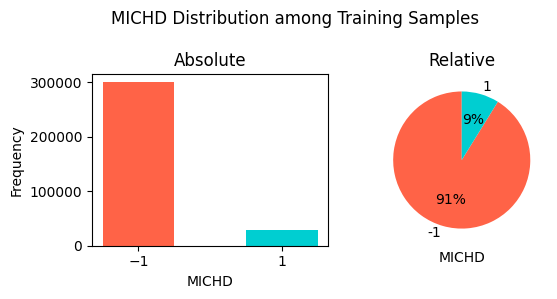

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (6,3))
plt.suptitle('MICHD Distribution among Training Samples')

# Bar plot
# Separate the -1 and 1 values into two arrays for plotting with different colors
y_train_neg = y_train[y_train == -1]
y_train_pos = y_train[y_train == 1]
ax1.hist(y_train_neg, bins=3, range=(-1.5, 1.5), color='tomato')
ax1.hist(y_train_pos, bins=3, range=(-1.5, 1.5), color='darkturquoise')
ax1.set_xticks([-1,1])
ax1.set_xlabel('MICHD')
ax1.set_ylabel('Frequency')
ax1.set_title('Absolute')

# Pie plot
# Return total count for each label
_ , counts = np.unique(y_train, return_counts=True)
labels = ['-1','1']
ax2.pie(counts,labels=labels, autopct='%1.0f%%', startangle=90, colors=['tomato', 'darkturquoise'])
ax2.set_xlabel('MICHD')
ax2.set_title('Relative')

plt.tight_layout()
plt.show()

- Clearly imbalanced data. Perhaps it will be necessary to apply certain strategies to mitifate uneven distribution of levels:
    - Resampling: Use oversampling  or undersampling to balance your data.
    - Class Weights: Adjust the weights in your model to handle the imbalance.
    - Adjust threshold of logistic regression

**1.2.3 Missing data**

**i. Missing data statistics**


Number of samples with at least one NaN: 328135 out of 328135
Number of features with at least one NaN: 239 out of 321


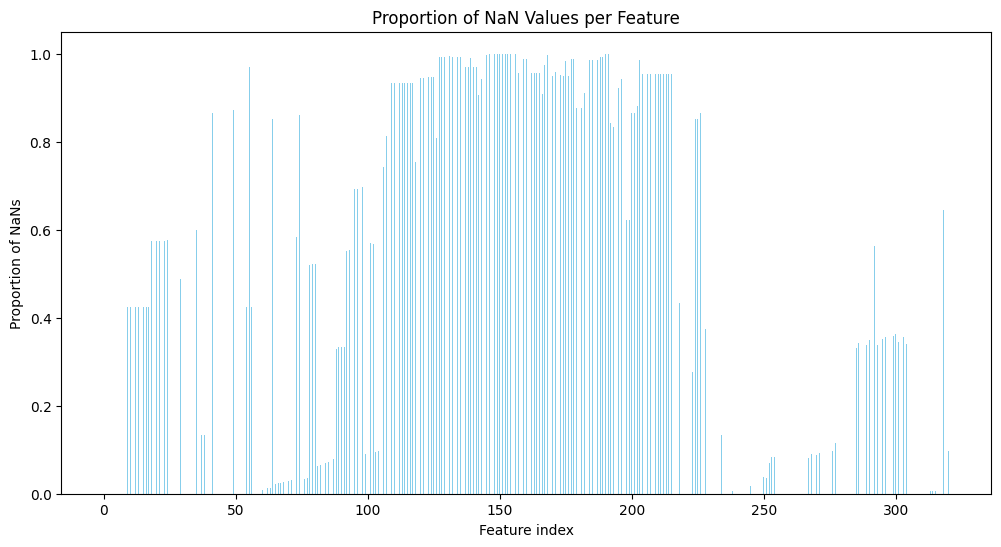

69% of columns have at least 1% missing values
57% of columns have at least 10% missing values
55% of columns have at least 25% missing values
46% of columns have at least 50% missing values
36% of columns have at least 75% missing values
31% of columns have at least 90% missing values


In [8]:
# i. Number of samples with at least one missing value
samples_with_nan = np.sum(np.any(np.isnan(x_train), axis=1))


print(f"Number of samples with at least one NaN: {samples_with_nan} out of {N_samples}")

# ii. Cols with missing values
feautures_with_nan = np.sum(np.any(np.isnan(x_train), axis=0) )
print(f"Number of features with at least one NaN: {feautures_with_nan} out of {N_features}")

nans_per_feature = np.sum(np.isnan(x_train), axis=0)  # Count NaNs in each column
proportion_of_nans = nans_per_feature / N_samples  # Proportion of NaNs in each column

# Plot distribution of missing values per feature
plt.figure(figsize=(12, 6))
plt.bar(range(0,N_features), proportion_of_nans, color='skyblue', width=0.3)
plt.title("Proportion of NaN Values per Feature")
plt.xlabel("Feature index")
plt.ylabel("Proportion of NaNs")
plt.show()

# Missing feature proportion thresholds
proportion_thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9] 

# Calculate how many features have a proportion of NaNs greater than threshold
stats = {}

for threshold in proportion_thresholds:
    cols_with_nans_above_threshold = np.sum(proportion_of_nans >= threshold)
    proportion_of_cols = cols_with_nans_above_threshold / len(proportion_of_nans) * 100
    stats[threshold] = proportion_of_cols
    
for threshold, proportion in stats.items():
    print(f"{proportion:.0f}% of columns have at least {threshold * 100:.0f}% missing values")


In [9]:
threshold = 0.75
high_missing_cols = np.sum(proportion_of_nans > threshold)
print(f"Number of columns with more than {threshold*100:.0f}% missing values: {high_missing_cols}")

Number of columns with more than 75% missing values: 117


**Conclusions**

- All samples have at least one missing value.
- Most columns (74.5%) have at least one missing value.
- **Approach**: not include features given a threshold for proportion of missing values
   - Initially, set threshold to 75% of missing values -> 36% of total columns (117 columns)


### Feature selection analysis

**Manual feature selection**

- **1. Blood Pressure**
    - `BPHIGH4`: Ever told you have high blood pressure.  
        - Values: Yes = 1,2 Yes, but female told only during pregnancy=2, No = 3, Told borderline = 4, Don't know/Refused = 7/9.
    - `BPMEDS`: Currently taking blood pressure medication.  
        - Values: Yes = 1, No = 2, Don’t know/Refused = 7/9.

- **2. Cholesterol**
    - `TOLDHI2`: Ever told your cholesterol is high.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.

- - **3. Sleep Patterns**
    - `ADSLEEP`: Trouble falling or staying asleep, or sleeping too much in the last 2 weeks?  
        - Values: Numeric (days)., 1 - 14  days; 88/77/99



- **4. Diabetes**
    - `DIABETE3`: Ever told you have diabetes.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `DIABAGE2`: Age when diagnosed with diabetes.  
        - Values: Numeric (age in years); 1-97; 98: not sure, 99=refused
    - `PDIABTST`: Have you had a test for high blood sugar or diabetes within the past three years?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.

- **5. Lifestyle Factors**
    - `SMOKE100`: Smoked at least 100 cigarettes in your life.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `SMOKDAY2`: Frequency of days currently smoking.  
        - Values: 1= every day; 2=some day; 3= not at all; 7/9: dont know/refused
    - `ALCDAY5` (two cols): Days in past 30 days with alcoholic beverage consumption.  
        - Values: Numeric (days).1(01) - 1(99) Days per week; 2(01) - 2(99) Days in past 30 days, 888: no drink, 777/999: dont know/refused
    - `AVEDRNK2`: Average number of drinks per day when drinking.  
        - Values: Numeric (number of drinks): 1-76; 77/99

- **6. Body Mass Index (BMI)**
    - `WEIGHT2`(Column: 178-181): Reported weight (numeric, pounds): 50 - (0)999 (pounds), (9)000 - (9)998 (kg) , 7777/9999 
    - `HEIGHT3`(182-185): Reported height (numeric, inches). 200 - 711 Height (ft/inches),  0 _ / _ _ = feet / inches, (9)000 - (9)998 Height (meters/centimeters), 7777/9999
    - **BMI**: Computed from weight and height.

- **7. Physical Health**
    - `PHYSHLTH`: Days in past 30 days when physical health was not good.  
        - Values: Numeric (days)., 1-30, 88: none, 77/99
    - `POORHLTH`: Days in past 30 days when physical or mental health kept you from usual activities.  (same)
        - Values: Numeric (days).
    - `ADENERGY`: Over the last 2 weeks, how many days have you felt tired or had little energy?  
        - Values: Numeric (days).01-14 days ; 88= none; 77/99

- **8. Health Care Access**
    - `HLTHPLN1`: Do you have health care coverage?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `CHECKUP1`: Time since last routine checkup.  
        - Values: Within past year = 1, 1-2 years = 2, 2-5 years = 3, 5+ years = 4, Never = 8, Don't know/Refused = 7/9.

- **9. Physical Activity**
    - `QLACTLM2`: Activity limitation due to health problems.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `EXERANY2`: Participated in physical activities outside of work in the past 30 days?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `STRENGTH`(244-246): Frequency of strength training in the past month.  
        - Values: Numeric (times per week/month), 101 - 199 Times per week, 201 - 299 Times per month, 888: never, 777/999
    - `EXEROFT1` (230-232): Frequency of physical activity in the past month.  How Many Times Walking, Running, Jogging, or Swimming
        - Values: Numeric (times per week/month). (same above, without 888)

- **10. Stress and Mental Health**
    - `MENTHLTH`: Days in past 30 days when mental health was not good.  
        - Values: Numeric (days). 1 - 30 Number of days; 88,77,99
    - `ADANXEV`: Ever told you have anxiety disorder?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `CIMEMLOS`: Experienced confusion or memory loss in the past year?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `ADDEPEV2`: Ever told you have a depressive disorder?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.

- **11. Diet**
    - `FRUTDA1_`: Frequency of fruit consumption per day.  0 - 9999 Times per day
    - `BEANDAY_`: Frequency of beans or lentils consumption per day.
    - `GRENDAY_`: Frequency of dark greens consumption per day.
    - `ORNGDAY_`: Frequency of orange-colored vegetables perday
    - `VEGEDA1_`: Frequency of other vegetables per week.
    - `DRADVISE`: Doctor advised to reduce sodium or salt intake.  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.

- **12. Comorbidities**
    - `CVDSTRK3`: Ever diagnosed with stroke?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `HAVARTH3`: Ever diagnosed with arthritis?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `CHCCOPD1`: Ever diagnosed with COPD?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `JOINPAIN`: Severity of joint pain in the past 30 days.  
        - Values: Numeric (scale). 0 - 10 Enter number, 77/99
    - `ASPUNSAF`: Is taking aspirin unsafe due to a health condition?  
        - Values: Yes, not stomach related = 1, Yes, stomach related = 2, No =3,  Don't know/Refused = 7/9.
    - `ASTHMA3`: Ever diagnosed with asthma?  
        - Values: Yes = 1, No = 2, Don't know/Refused = 7/9.
    - `ASTHMAGE`: How old were you when you were first told by a doctor, nurse or other health professional that you had asthma?
        - Values: 11 - 96 Age 11 or older, 97: 10 or younger, 98: dont know; 99: refused

- **13. Age, Gender and Race**
   
    - `_AGEG5YR`: (Five-Year Age Categories)

        - Numeric:  1-13; 14: Not known/missing
        - Also for age:  - `AGE`: Respondent's age (numeric): 18-90, 7/9, `_AGE65YR`: 2 LEVEL age category; 18-64:1 ; > 65; 7/9 (also 14 group)
    - `SEX`: Respondent's gender (male = 1, female = 2).
    - `_RACEGR3`: 
  
        - Values: categorical: 1 = White only (Non-Hispanic), 2 = Black only (Non-Hispanic) ,   3  = Other race only (Non-Hispanic), 4 = Multiracial (Non-Hispanic), 5 = Hispanic , 9= Don’t know/Not sure/Refused
        - Likely to be the most useful for studying myocardial infarction risk. It combines a small number of categories, differentiates Hispanic origin, and includes distinctions for White, Black, multiracial, and other races.




In [10]:
target_features = [
    "BPHIGH4", "BPMEDS", "TOLDHI2", "DIABETE3", "DIABAGE2", "PDIABTST",
    "SMOKE100", "SMOKDAY2", "ALCDAY5", "AVEDRNK2", "WEIGHT2", "HEIGHT3", "PHYSHLTH",
    "POORHLTH", "ADENERGY", "HLTHPLN1", "CHECKUP1", "QLACTLM2", "EXERANY2", "STRENGTH", 
    "EXEROFT1", "MENTHLTH", "ADANXEV", "CIMEMLOS", "ADDEPEV2", "FRUTDA1_",
     "BEANDAY_","GRENDAY_", "ORNGDAY_","VEGEDA1_", "DRADVISE", "CVDSTRK3", "HAVARTH3", 
    "CHCCOPD1", "JOINPAIN", "ASPUNSAF", "ASTHMA3", "ASTHMAGE", 
    "SEX", "ADSLEEP", "_AGEG5YR","_RACEGR3"
]


In [11]:
#  Check all features are present in available features

for feature in target_features:
    try:
        idx = features.index(feature)  # Find the index of each target feature 
    except ValueError:
        print(f"Feature '{feature}' is not in the list of features, possible exclusion or error.")

**Missing value analysis based on NaNs**

In [36]:
# Ensure indexes align directly with target_features
indexes_target_features = [features.index(feature) for feature in target_features if feature in features]

# Count NaNs in each target column and calculate proportions
nans_per_target_feature = np.sum(np.isnan(x_train[:, indexes_target_features]), axis=0)
N_samples = x_train.shape[0]
proportion_of_nans_per_target = nans_per_target_feature / N_samples  # Proportion per column

list_CVD = []


for i, feature in enumerate(target_features):
    if feature in features:
        index = features.index(feature)  # index in features

        #Chek how much of the non-NaN values are 1
        sum_CVD = 0
        position = 0
        count = 0
        for value in x_train[:, index]:
            if not np.isnan(value) :
                count += 1
                if y_train[position] == 1:
                    sum_CVD += 1
            position += 1

        proportion_CVD = sum_CVD / count
        if proportion_CVD > 0.5:
            list_CVD.append(feature)
        proportion = proportion_of_nans_per_target[i]  # proportion for each feature
        print(f"Feature '{feature}' (Column {index}): {proportion:.2%} ; Proportion of CVD: {proportion_CVD:.2%}")
    else:
        print(f"Feature '{feature}' is missing from the dataset.")

print(f"Features with more than 50% of CVD: {list_CVD}")

Feature 'BPHIGH4' (Column 34): 0.00% ; Proportion of CVD: 8.83%
Feature 'BPMEDS' (Column 35): 59.83% ; Proportion of CVD: 16.34%
Feature 'TOLDHI2' (Column 38): 13.35% ; Proportion of CVD: 9.81%
Feature 'DIABETE3' (Column 48): 0.00% ; Proportion of CVD: 8.83%
Feature 'DIABAGE2' (Column 49): 87.13% ; Proportion of CVD: 22.13%
Feature 'PDIABTST' (Column 107): 81.27% ; Proportion of CVD: 7.98%
Feature 'SMOKE100' (Column 72): 3.21% ; Proportion of CVD: 8.87%
Feature 'SMOKDAY2' (Column 73): 58.32% ; Proportion of CVD: 12.42%
Feature 'ALCDAY5' (Column 77): 3.59% ; Proportion of CVD: 8.87%
Feature 'AVEDRNK2' (Column 78): 52.08% ; Proportion of CVD: 6.37%
Feature 'WEIGHT2' (Column 62): 1.20% ; Proportion of CVD: 8.85%
Feature 'HEIGHT3' (Column 63): 1.34% ; Proportion of CVD: 8.85%
Feature 'PHYSHLTH' (Column 27): 0.00% ; Proportion of CVD: 8.83%
Feature 'POORHLTH' (Column 29): 48.72% ; Proportion of CVD: 11.30%
Feature 'ADENERGY' (Column 209): 95.39% ; Proportion of CVD: 11.67%
Feature 'HLTHPLN1

- Checked for `DIABAGE2`, `SEX`, `DIABETES3` (same proportion as indicated in dataset)

In [13]:
# Define threshold for missing values
threshold = 0.1

# Ensure that indexes match correctly by creating a dictionary of proportions keyed by feature names
proportion_dict = dict(zip(target_features, proportion_of_nans_per_target))

# Filter out features based on the threshold
filtered_features = [feature for feature, proportion in proportion_dict.items() if proportion <= threshold]
eliminated_features =  [feature for feature, proportion in proportion_dict.items() if proportion > threshold]

print("Features with missing value proportion below the threshold:")
print(filtered_features)
print("Features with missing value proportion above the threshold:")
print(eliminated_features)

Features with missing value proportion below the threshold:
['BPHIGH4', 'DIABETE3', 'SMOKE100', 'ALCDAY5', 'WEIGHT2', 'HEIGHT3', 'PHYSHLTH', 'HLTHPLN1', 'CHECKUP1', 'QLACTLM2', 'EXERANY2', 'STRENGTH', 'MENTHLTH', 'ADDEPEV2', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'ASTHMA3', 'SEX', '_AGEG5YR', '_RACEGR3']
Features with missing value proportion above the threshold:
['BPMEDS', 'TOLDHI2', 'DIABAGE2', 'PDIABTST', 'SMOKDAY2', 'AVEDRNK2', 'POORHLTH', 'ADENERGY', 'EXEROFT1', 'ADANXEV', 'CIMEMLOS', 'DRADVISE', 'JOINPAIN', 'ASPUNSAF', 'ASTHMAGE', 'ADSLEEP']


In [14]:
# Define threshold for missing values
threshold = 0.7

# Ensure that indexes match correctly by creating a dictionary of proportions keyed by feature names
proportion_dict = dict(zip(target_features, proportion_of_nans_per_target))

# Filter out features based on the threshold
filtered_features = [feature for feature, proportion in proportion_dict.items() if proportion <= threshold]
eliminated_features =  [feature for feature, proportion in proportion_dict.items() if proportion > threshold]

print("Features with missing value proportion below the threshold:")
print(filtered_features)
print("Features with missing value proportion above the threshold:")
print(eliminated_features)

Features with missing value proportion below the threshold:
['BPHIGH4', 'BPMEDS', 'TOLDHI2', 'DIABETE3', 'SMOKE100', 'SMOKDAY2', 'ALCDAY5', 'AVEDRNK2', 'WEIGHT2', 'HEIGHT3', 'PHYSHLTH', 'POORHLTH', 'HLTHPLN1', 'CHECKUP1', 'QLACTLM2', 'EXERANY2', 'STRENGTH', 'EXEROFT1', 'MENTHLTH', 'ADDEPEV2', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', 'CVDSTRK3', 'HAVARTH3', 'CHCCOPD1', 'JOINPAIN', 'ASTHMA3', 'SEX', '_AGEG5YR', '_RACEGR3']
Features with missing value proportion above the threshold:
['DIABAGE2', 'PDIABTST', 'ADENERGY', 'ADANXEV', 'CIMEMLOS', 'DRADVISE', 'ASPUNSAF', 'ASTHMAGE', 'ADSLEEP']


**Range of values for each category (<0.7 missing values)**

- **Binary** (Yes=1, No=2, Don't know/refuse=7,9)
        - `BPMEDS`, `TOLDHI2` , `DIABETE3`, `HLTHPLN1`, `QLACTLM2`, `EXERANY2`, `ADDEPEV2`, `ASTHMA3`, `SMOKE100`,
        `CVDSTRK3`, `HAVARTH3`, `CHCCOPD1`, `SEX`

    
    `BPHIGH4`:- Values: Yes = 1,2 Yes, but female told only during pregnancy=2, No = 3, Told borderline = 4, Don't know/Refused = 7/9.


   
    `_RACEGR3`: 

    - Values: categorical: 1 = White only (Non-Hispanic), 2 = Black only (Non-Hispanic) ,   3  = Other race only (Non-Hispanic), 4 = Multiracial (Non-Hispanic), 5 = Hispanic , 
     9= Don’t know/Not sure/Refused


- **Numeric**
    
    - `SMOKDAY2`:  Values: 1= every day; 2=some day; 3= not at all; 7/9: dont know/refused
    - `ALCDAY5`: 1(01) - 1(99) Days per week; 2(01) - 2(99) Days in past 30 days, 888: no drink, 777/999: dont know/refused
    - `AVEDRNK2`: 1-76; 77/99
    - `WEIGHT2`(Column: 178-181): Reported weight (numeric, pounds): 50 - (0)999 (pounds), (9)000 - (9)998 (kg) , 7777/9999 
    - `HEIGHT3`(182-185): Reported height (numeric, inches). 200 - 711 Height (ft/inches),  0 _ / _ _ = feet / inches, (9)000 - (9)998 Height (meters/centimeters), 7777/9999
    -`POORHLTH`: 1-30, 88: none, 77/99
    - `CHECKUP1`:  Within past year = 1, 1-2 years = 2, 2-5 years = 3, 5+ years = 4, Never = 8, Don't know/Refused = 7/9
    -  `STRENGTH`(244-246): (times per week/month), 101 - 199 Times per week, 201 - 299 Times per month, 888: never, 777/999
    - `EXEROFT1` (230-232): (times per week/month). (same above, without 888)
    - `MENTHLTH`:  1 - 30 Number of days; 88,77,99
    - `FRUTDA1_`: 0 - 9999 
    - `VEGEDA1_`: 0 - 9999 
    - `GRENDAY_`: 0 - 9999 
    - `ORGNDAY`: 0 - 9999 
    - `BEANDAY_`: 0-9999
    - `PHYSHLTH`: 1-30, 88: none, 77/99
    - `JOINPAIN`: 0-10; 77/99
    - `_AGEG5YR`: 1-13; 14: dont know
    -  `CHECKUP1`: Within past year = 1, 1-2 years = 2, 2-5 years = 3, 5+ years = 4, Never = 8, Don't know/Refused = 7/9.

# 3. Training model
**Stategy**
- Set up baseline model (from original data without modifications) and progressively, finetune it with respect to :
    - Missing values
    - Data imbalance
    - Feature importance

- **Baseline model**: manually selected features with 0 missing values (nan)
    - 'HLTHPLN1', 'MENTHLTH', 'ADDEPEV2', 'CVDSTRK3', 'CHCCOPD1', 'ASTHMA3', 'SEX', '_AGEG5YR', '_RACEGR3'
    - First try only with non missing values rows

    - Strategy

        - **Binary variables** ( 'HLTHPLN1', 'ADDEPEV2', 'CVDSTRK3', 'CHCCOPD1','SEX','ASTHMA3')
        - **Categorical variables** ('_RACEGR3')
        - **Numeric variables with ranges** ('MENTHLTH','_AGEG5YR')

In [15]:
# Substitute missing value by 0
#X_train = np.where(np.isnan(x_train), 0, x_train)
# Since logistic regression functions have been designed for 0 and 1 values, -1 values in Y array need to be changed to 0
# Replace all -1 values with 0
Y_train = np.where(y_train == -1, 0, y_train)

In [16]:
features_dict = {
    # Binary variables
    'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'ADDEPEV2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'SEX': {'type': 'binary', 'missing_values': [np.nan]},
    'ASTHMA3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    
    # Categorical variable
    '_RACEGR3': {
        'type': 'categorical', 
        'missing_values': [9, np.nan],
        'categories': [1, 2, 3, 4, 5]  
    },
    
    # Numeric variables with ranges
    'MENTHLTH': {
        'type': 'numeric', 
        'missing_values': [77, 88, 99, np.nan],
        'range': (1, 30),  
        'map_value': {88: 0} 
    },
    '_AGEG5YR': {
        'type': 'numeric', 
        'missing_values': [14, np.nan],
        'range': (1, 13)  
    }
}

In [17]:
# Get indices for each feature
feature_indices = {feature: features.index(feature) for feature in features_dict.keys()}

# Create a mask array to track rows with missing values in any feature
missing_rows = np.zeros(x_train.shape[0], dtype=bool)

# Check for missing values in each specified feature
for feature, info in features_dict.items():
    feature_idx = feature_indices[feature]
    missing_values = info['missing_values']
    
    # Create a mask for the current feature indicating rows with missing values
    if np.nan in missing_values:
        feature_mask = np.isin(x_train[:, feature_idx], missing_values[:-1]) | np.isnan(x_train[:, feature_idx])
    else:
        feature_mask = np.isin(x_train[:, feature_idx], missing_values)
    
    # Update the overall missing_rows mask
    missing_rows |= feature_mask

# Count the rows with at least one missing value in the selected features
num_missing_rows = np.sum(missing_rows)
print(f"Percentage of rows with at least one missing value in specified features: {num_missing_rows/N_samples*100:.2f}% ({num_missing_rows} samples)")

Percentage of rows with at least one missing value in specified features: 71.24% (233761 samples)


In [18]:
# Only selecting samples with no missing value for training -> NO MISSING VALUES
missing_rows = np.zeros(x_train.shape[0], dtype=bool)

for feature, info in features_dict.items():
    feature_idx = feature_indices[feature]
    missing_values = info['missing_values']
    
    # Create a mask for current feature indicating rows with missing values
    if np.nan in missing_values:
        feature_mask = np.isin(x_train[:, feature_idx], missing_values[:-1]) | np.isnan(x_train[:, feature_idx])
    else:
        feature_mask = np.isin(x_train[:, feature_idx], missing_values)
    
    # Update the overall missing_rows mask
    missing_rows |= feature_mask

# Step 2: Filter X_train and y_train based on the missing_rows mask
X_train_filtered = x_train[~missing_rows]
Y_train_filtered = Y_train[~missing_rows]

In [19]:
def transform_features_no_missing(X, features_dict, original_features):
    """
    Transforms the features in X based on the encoding specified in features_dict,
    assuming there are no missing values.
    
    Args:
    - X: The input NumPy array (original dataset).
    - features_dict: Dictionary defining feature types and encoding.
    - original_features: List of feature names in the original order of X.
    
    Returns:
    - X_transformed: NumPy array with transformed features in the specified format.
    """
    transformed_features = []  # List to store transformed feature arrays
    
    for feature, info in features_dict.items():
        feature_idx = original_features.index(feature)
        feature_values = X[:, feature_idx]
        
        if info['type'] == 'binary':
            # Binary variables: map Yes=1 -> 1 and No=2 -> 0
            feature_transformed = np.where(feature_values == 1, 1, 0)
            transformed_features.append(feature_transformed.reshape(-1, 1))
        
        elif info['type'] == 'categorical':
            # One-hot encode categorical features, with a column for each category
            categories = info.get('categories', [])
            for cat in categories:
                # Create a binary column for each category value
                category_mask = (feature_values == cat).astype(int)
                transformed_features.append(category_mask.reshape(-1, 1))
        
        elif info['type'] == 'numeric':
            # Handle special values (e.g., 88 as 0 in MENTHLTH)
            special_values = info.get('map_value', {})
            for special, replacement in special_values.items():
                feature_values = np.where(feature_values == special, replacement, feature_values)
            
            # Directly append the numeric feature after applying special value transformation
            transformed_features.append(feature_values.reshape(-1, 1))
    
    # Concatenate all transformed features to form the final transformed dataset
    X_transformed = np.hstack(transformed_features)
    return X_transformed

# Example usage
# Assuming X_train is your data array, original_features is the full feature list
X_train_transformed = transform_features_no_missing(X_train_filtered, features_dict, features)

**No regularization**

  0%|          | 0/10 [00:00<?, ?it/s]

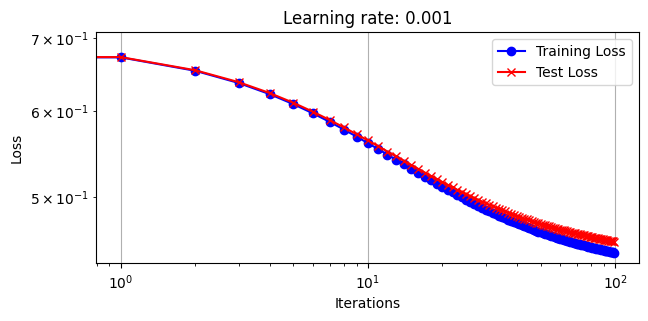

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Learning rate = 0.001; Average train loss = 0.44554839471654145; Average test loss: 0.44556654883878616


  0%|          | 0/10 [00:00<?, ?it/s]

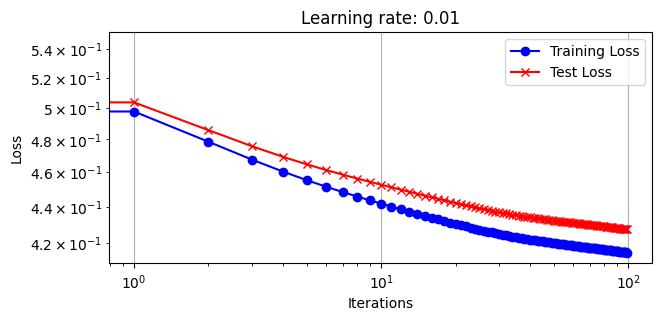

100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


Learning rate = 0.01; Average train loss = 0.41582129136179613; Average test loss: 0.4158508825504579


  0%|          | 0/10 [00:00<?, ?it/s]

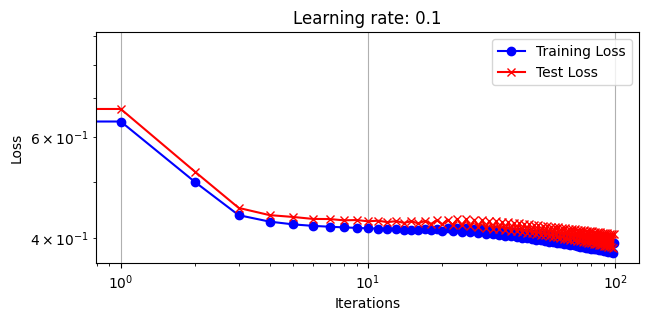

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

Learning rate = 0.1; Average train loss = 0.3931146089111307; Average test loss: 0.3930946702721382
Best learning rate: 0.1 with test MSE: 0.3930946702721382


(0.1,
 0.3930946702721382,
 {0.1: 0.3930946702721382,
  0.01: 0.4158508825504579,
  0.001: 0.44556654883878616})

In [20]:

# NO REGULARIZATION
k_fold_cross_validation(X_train_transformed, Y_train_filtered, max_iters=100, gammas=[0.001, 0.01, 0.1], K=10, seed=10,reg_norm='')

**L1 regularization**

  0%|          | 0/10 [00:00<?, ?it/s]

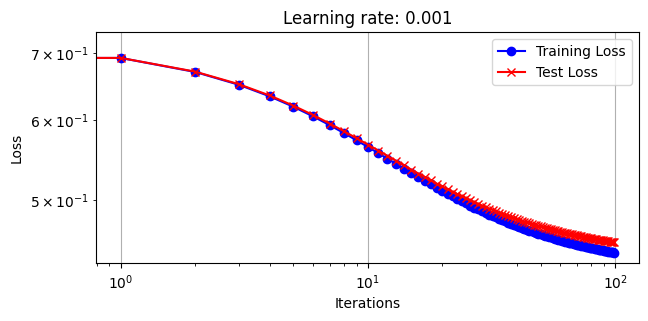

100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Learning rate = 0.001; Average train loss = 0.4442899059527862; Average test loss: 0.4443078230852854


  0%|          | 0/10 [00:00<?, ?it/s]

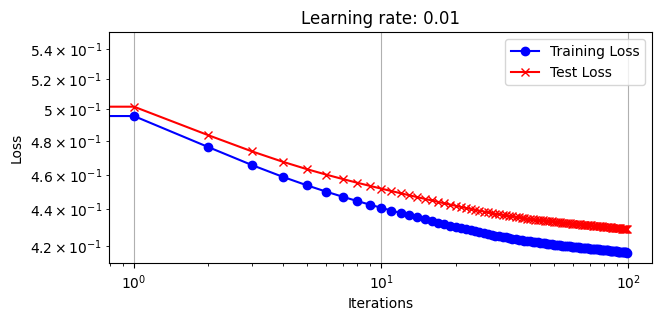

100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Learning rate = 0.01; Average train loss = 0.41759588321984104; Average test loss: 0.4176240407799442


  0%|          | 0/10 [00:00<?, ?it/s]

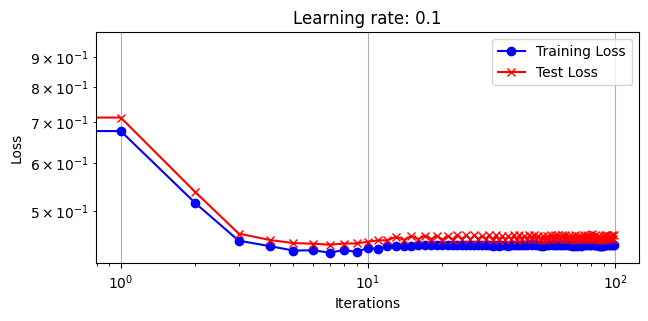

100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

Learning rate = 0.1; Average train loss = 0.4409768204599159; Average test loss: 0.44092081482012624
Best learning rate: 0.01 with test MSE: 0.4176240407799442


(0.01,
 0.4176240407799442,
 {0.01: 0.4176240407799442,
  0.1: 0.44092081482012624,
  0.001: 0.4443078230852854})

In [21]:
k_fold_cross_validation(X_train_transformed, Y_train_filtered, max_iters=100, gammas=[0.001, 0.01, 0.1], K=10, seed=10,reg_norm='l1')

**L2 regularization**

  0%|          | 0/10 [00:00<?, ?it/s]

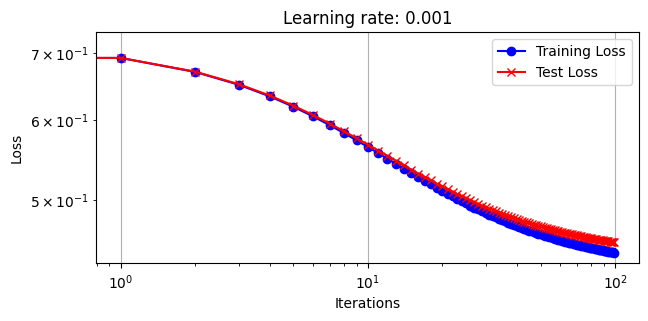

100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Learning rate = 0.001; Average train loss = 0.44425845349969073; Average test loss: 0.44427637705578815


  0%|          | 0/10 [00:00<?, ?it/s]

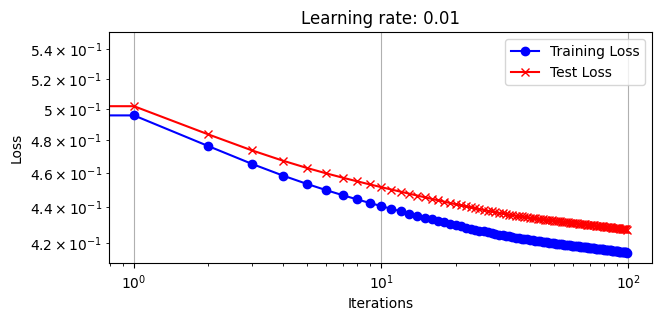

100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Learning rate = 0.01; Average train loss = 0.4160051275003518; Average test loss: 0.41603459911969753


  0%|          | 0/10 [00:00<?, ?it/s]

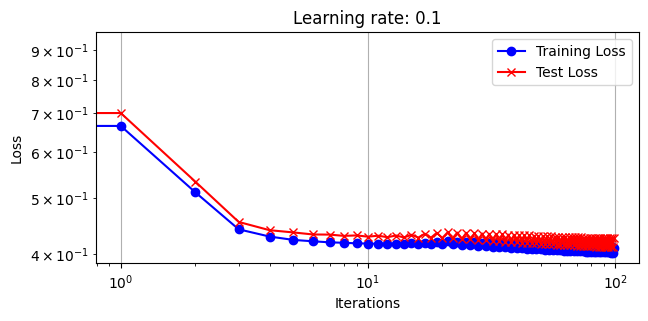

100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

Learning rate = 0.1; Average train loss = 0.4127661434202635; Average test loss: 0.41272894923300585
Best learning rate: 0.1 with test MSE: 0.41272894923300585


(0.1,
 0.41272894923300585,
 {0.1: 0.41272894923300585,
  0.01: 0.41603459911969753,
  0.001: 0.44427637705578815})

In [22]:
k_fold_cross_validation(X_train_transformed, Y_train_filtered, max_iters=100, gammas=[0.001, 0.01, 0.1], K=10, seed=10,reg_norm='l2')